# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import datetime
import time
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml import pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Saprkify Project") \
        .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '27c786fb1a9c'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Saprkify Project'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1595361947240'),
 ('spark.driver.port', '41741')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [7]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18


In [8]:
# drop missing values
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [9]:
df = df[df.userId != ""]
df.count()

278154

In [10]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
+------+
only showing top 10 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
for col in df.columns:
    print(col)
    print('_________________________')
    df.describe(col).show()
    print(' ')

artist
_________________________
+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

 
auth
_________________________
+-------+---------+
|summary|     auth|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min|Cancelled|
|    max|Logged In|
+-------+---------+

 
firstName
_________________________
+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

 
gender
_________________________
+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

 
itemInSession
_________________________
+-------+------------------+
|summary|   

In [12]:
df1 = df.toPandas()
df1.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [13]:
tss = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_registration', tss('registration'))
df = df.withColumn('updated_ts', tss('ts'))

In [14]:
# define a downgrade label
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_value", downgrade_value("page"))

# find all users who downgraded
dg_window = Window.partitionBy('UserId')
df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

# define a churn label
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

# find all users who churned
churn_window = Window.partitionBy('UserId')
df = df.withColumn("user_churn", max('churn_value').over(churn_window))

# selecting few users to see
df.select(['userId', 'firstName', 'level','updated_ts','user_churn', 'user_downgrade']).dropDuplicates(subset = ['userId']).show(10)

+------+---------+-----+-------------------+----------+--------------+
|userId|firstName|level|         updated_ts|user_churn|user_downgrade|
+------+---------+-----+-------------------+----------+--------------+
|100010| Darianna| free|10-08-2018 12:58:54|         0|             0|
|200002|  Dominic| free|10-01-2018 11:30:30|         0|             0|
|   125|    Mason| free|10-12-2018 04:05:44|         1|             0|
|   124|   Nicole| paid|10-01-2018 15:17:10|         0|             0|
|    51|    Ethan| paid|10-01-2018 12:57:12|         1|             0|
|     7|   Maddox| free|10-03-2018 11:57:49|         0|             0|
|    15|    Panav| paid|10-01-2018 10:23:35|         0|             0|
|    54|    Alexi| paid|10-01-2018 00:32:10|         1|             1|
|   155|   Camila| free|11-02-2018 15:56:25|         0|             0|
|100014|  Rodrigo| paid|10-10-2018 13:12:16|         1|             0|
+------+---------+-----+-------------------+----------+--------------+
only s

In [15]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [16]:
df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").show()

+----------+------+-----+
|user_churn|gender|count|
+----------+------+-----+
|         0|     M|   89|
|         0|     F|   84|
|         1|     F|   20|
|         1|     M|   32|
+----------+------+-----+



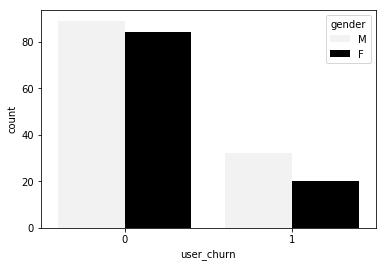

In [17]:

# Plotting a bar plot to show gender distribution between regular and churn users
df_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_pd, hue = 'gender', color = 'black');

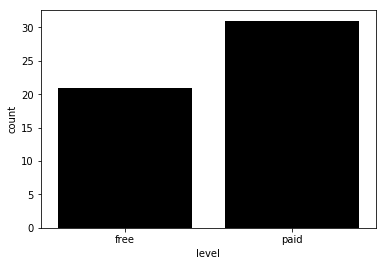

In [18]:
# Finding out which level customers churn more
level = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level, x = 'level', y = 'count', color = 'black')

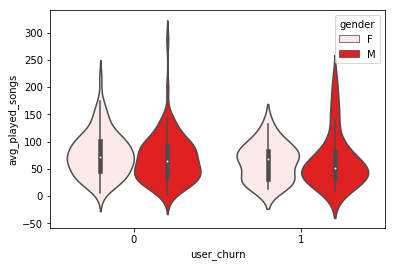

In [19]:
# observe the gender distribution for number of songs played per session for churned and normal users
total_songs = df.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

ax = sns.violinplot('user_churn', y = 'avg_played_songs', hue = 'gender', color = 'red', data = total_songs)

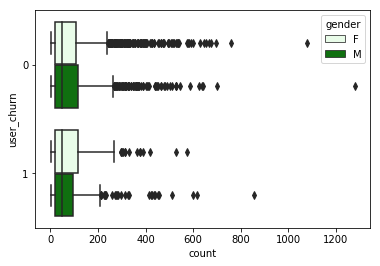

In [21]:
# observe the gender distribution for total operations per session between normal and churned users
df_op = df.groupby("user_churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'user_churn', orient = 'horizontal', color = 'green', data = df_op, hue = 'gender')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
# Feature 1 : Total number of  songs listened
feature_1 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')
feature_1.show()

+------+---------+
|userId|tot_songs|
+------+---------+
|100010|      381|
|200002|      474|
|   125|       11|
|    51|     2464|
|   124|     4825|
|     7|      201|
|    54|     3437|
|    15|     2278|
|   155|     1002|
|   132|     2304|
|   154|      118|
|100014|      310|
|   101|     2149|
|    11|      848|
|   138|     2469|
|300017|     4428|
|    29|     3603|
|    69|     1342|
|100021|      319|
|    42|     4257|
+------+---------+
only showing top 20 rows



In [23]:
# Feature 2 : Number of thumbs up
feat_2 = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_up')
feat_2.show()

+------+-------------+
|userId|tot_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
|    15|           81|
|   155|           58|
|   132|           96|
|   154|           11|
|100014|           17|
|   101|           86|
|    11|           40|
|   138|           95|
|300017|          303|
|    29|          154|
|    69|           72|
|100021|           11|
|    42|          166|
|   112|            9|
+------+-------------+
only showing top 20 rows



In [24]:
# Feature 3 : Number of thumbs down
feat_3 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')
feat_3.show()

+------+---------------+
|userId|tot_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|   132|             17|
|100014|              3|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|    29|             22|
|    69|              9|
|100021|              5|
|    42|             25|
|   112|              3|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [37]:
# Feature 4 : Total time since registration
feat_4 = df.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))
feat_4.show()

TypeError: 'str' object is not callable

In [26]:
# Feature 5 : Total length of listening utilizing all services
feat_5 = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'tot_listen_time')
feat_5.show()

+------+------------------+
|userId|   tot_listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [27]:
# Feature 6 : Total number of friends
feat_6 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')
feat_6.show()

+------+-----------+
|userId|tot_friends|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
|   124|         74|
|     7|          1|
|    54|         33|
|    15|         31|
|   155|         11|
|   132|         41|
|   154|          3|
|100014|          6|
|   101|         29|
|    11|          6|
|   138|         41|
|300017|         63|
|    29|         47|
|    69|         12|
|100021|          7|
|    42|         52|
|   112|          7|
+------+-----------+
only showing top 20 rows



In [29]:
# Feature 7 : Gender of the user
feat_7 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

feat_7.show()

TypeError: 'str' object is not callable

In [30]:
# Feature 8 : Total number of songs listened per session
feat_8  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

feat_8.show()

+------+------------------+
|userId|  avg_played_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [28]:
# Feature 6 : Total number of friends
feat_6 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')
feat_6.show()

+------+-----------+
|userId|tot_friends|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
|   124|         74|
|     7|          1|
|    54|         33|
|    15|         31|
|   155|         11|
|   132|         41|
|   154|          3|
|100014|          6|
|   101|         29|
|    11|          6|
|   138|         41|
|300017|         63|
|    29|         47|
|    69|         12|
|100021|          7|
|    42|         52|
|   112|          7|
+------+-----------+
only showing top 20 rows



In [31]:
# Feature 9 : Total number of artists the user has listened to
feat_9 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")
feat_9.show()

+------+-----------------+
|userId|tot_artist_played|
+------+-----------------+
|100010|              252|
|200002|              339|
|   125|                8|
|    51|             1385|
|   124|             2232|
|     7|              142|
|    15|             1302|
|    54|             1744|
|   155|              643|
|   132|             1299|
|   154|               78|
|100014|              233|
|   101|             1241|
|    11|              534|
|   138|             1332|
|300017|             2070|
|    29|             1804|
|    69|              865|
|100021|              207|
|    42|             2073|
+------+-----------------+
only showing top 20 rows



In [32]:
# setting the churn label for our model
target = df.select('userId', col('user_churn').alias('target')).dropDuplicates()
target.show()

TypeError: 'str' object is not callable

In [36]:
# Combining all features with the target churn label

final_data = feature_1.join(feat_2, 'userId', 'inner').join(feat_3, 'userId', 'inner').\
             .join(feat_5, 'userId', 'inner').join(feat_6, 'userId', 'inner').\
             .join(feat_8, 'userId', 'inner').join(feat_9, 'userId', 'inner').join(target, 'userId', 'inner').drop('userId')

final_data.show()

SyntaxError: invalid syntax (<ipython-input-36-a6a540ff64b7>, line 3)

In [34]:
final_pd = final_data.toPandas()

NameError: name 'final_data' is not defined

In [35]:
final_pd.isnull().sum()

NameError: name 'final_pd' is not defined

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
# We need to vectorize all of our features

ipcols = ['tot_songs', 'tot_thumbs_up', 'tot_thumbs_down', 'tot_lifetime', 'tot_listen_time', 'tot_friends', 'gender', 'avg_played_songs', 'tot_artist_played']
assmblr = VectorAssembler(inputCols = ipcols, outputCol = "VectFeature")
final_datas = assmblr.transform(final_data)
final_datas.show()

NameError: name 'final_data' is not defined

In [39]:
#  Standardizing all input features so none of them has more weightage compared to others
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

NameError: name 'final_data' is not defined

In [40]:
data = final_data.select(final_data.target.alias("label"), final_data.newFeatures.alias("features"))

NameError: name 'final_data' is not defined

In [41]:
data.show()

NameError: name 'data' is not defined

In [42]:
train, val = data.randomSplit([0.85, 0.15], seed = 42)
train = train.cache()

NameError: name 'data' is not defined

In [43]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [44]:
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

NameError: name 'train' is not defined

In [45]:
res_rf = cv_model_rf.transform(val)

NameError: name 'cv_model_rf' is not defined

In [46]:
# Getting different evaluation metrics for Random Forest
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our Random Forest Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})))

The metrics for our Random Forest Classifier are as follows :


NameError: name 'res_rf' is not defined

In [47]:
# SVM
svm_clf = LinearSVC(maxIter = 15)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

cross_val_svm = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [48]:
cv_model_svm = cross_val_svm.fit(train)
cv_model_svm.avgMetrics

NameError: name 'train' is not defined

In [49]:
res_svm = cv_model_svm.transform(val)

NameError: name 'cv_model_svm' is not defined

In [50]:
# Getting different evaluation metrics for SVM 
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our Support Vector Machine classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_svm, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_svm, {evaluator.metricName : "f1"})))

The metrics for our Support Vector Machine classifier are as follows: 


NameError: name 'res_svm' is not defined

In [51]:
# Gradient Boosted Trees
gbt_clf = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

cross_val_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [52]:
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

NameError: name 'train' is not defined

In [53]:
res_gbt = cv_model_gbt.transform(val)

NameError: name 'cv_model_gbt' is not defined

In [54]:
# Getting different evaluation metrics for Gradient Boosted Trees
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our Gradient Boosted Trees Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "f1"})))

The metrics for our Gradient Boosted Trees Classifier are as follows: 


NameError: name 'res_gbt' is not defined

In [55]:
# Tuning Hyperparameters for the Gradient Boosting Trees model using Grid Search
gbt_clf = GBTClassifier(maxIter = 15, seed = 42)

param_grid_gbt = ParamGridBuilder().addGrid(gbt_clf.maxIter, [10, 15, 20])\
                 .addGrid(gbt_clf.maxDepth, [5, 10]).build()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

cross_val_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid_gbt, evaluator = f1_evaluation, numFolds = 2)

In [56]:
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

NameError: name 'train' is not defined

In [57]:
# Choosing the parameters with best metrics
gbt_final = GBTClassifier(maxIter = 15 , seed = 42, maxDepth = 5)
gbt_final_model = gbt_final.fit(train)
res_final = gbt_final_model.transform(val)

NameError: name 'train' is not defined

In [58]:
# Getting final evaluation metrics for Gradient Boosted Trees
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The final metrics for our Gradient Boosted Trees Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "f1"})))

The final metrics for our Gradient Boosted Trees Classifier are as follows: 


NameError: name 'res_gbt' is not defined

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.